<a href="https://colab.research.google.com/github/abhinav-exp/Forecasting-CryptoCurrency-Prices/blob/master/TFLANN_with_JAYA-lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
GitHubDataLink = 'https://raw.githubusercontent.com/abhinav-exp/Forecasting-CryptoCurrency-Prices/master/Datasets/'
InputFileLink = GitHubDataLink + 'DataBTC2017.csv'
data1 = pd.read_csv(InputFileLink, header=0, index_col=0)
print(data1)

            CBBTCUSD
DATE                
2017-06-18   2515.25
2017-06-19   2596.98
2017-06-20   2725.08
2017-06-21   2643.35
2017-06-22   2679.99
...              ...
2019-08-03  10820.75
2019-08-04  10997.82
2019-08-05  11775.14
2019-08-06  11440.08
2019-08-07  12014.41

[781 rows x 1 columns]


In [ ]:
data1min = data1.min()
data1max = data1.max()

normalize = lambda x: (x - data1min + 1)/(data1max - data1min + 2)
data2 = normalize(data1)
print(data2)

            CBBTCUSD
DATE                
2017-06-18  0.034073
2017-06-19  0.038680
2017-06-20  0.045901
2017-06-21  0.041294
2017-06-22  0.043360
...              ...
2019-08-03  0.502247
2019-08-04  0.512228
2019-08-05  0.556045
2019-08-06  0.537158
2019-08-07  0.569532

[781 rows x 1 columns]


In [ ]:
def split_sequence(sequence, n_steps):
  X= list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x= sequence.values[i:end_ix, 0]
    X.append(seq_x) 
  return pd.DataFrame(X)

data3 = split_sequence(data2, 10)
print(data3.shape)
print(data3)

(771, 10)
            0         1         2         3         4         5         6  \
0    0.034073  0.038680  0.045901  0.041294  0.043360  0.043967  0.037432   
1    0.038680  0.045901  0.041294  0.043360  0.043967  0.037432  0.033530   
2    0.045901  0.041294  0.043360  0.043967  0.037432  0.033530  0.028023   
3    0.041294  0.043360  0.043967  0.037432  0.033530  0.028023  0.037484   
4    0.043360  0.043967  0.037432  0.033530  0.028023  0.037484  0.036208   
..        ...       ...       ...       ...       ...       ...       ...   
766  0.441959  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307   
767  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562   
768  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501   
769  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030   
770  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030  0.502247   

            7         8         9  
0    0.033530  0.028023  0.03

In [ ]:
train_x = data3.iloc[:int(0.85*len(data2)), :9]
train_y = data3.iloc[:int(0.85*len(data2)), 9:10]
test_x = data3.iloc[int(0.85*len(data2)):, :9]
test_y = data3.iloc[int(0.85*len(data2)):, 9:10]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(663, 9)
(663, 1)
(108, 9)
(108, 1)


In [ ]:
class TFLANN():
  def __init__(self, W):
    self.weight_matrix = W
  
  def func_x(self, x):
    const_x = np.ones((len(x), 1))
    orginal_x = x
    sinned_x = np.sin(np.pi*x)
    cossed_x = np.cos(np.pi*x)
    functioned_x = np.hstack((x, sinned_x, cossed_x, const_x))
    return functioned_x

  def forward_propagation(self, x):
    funced_x = self.func_x(x)
    return (np.tanh(np.dot(funced_x, self.weight_matrix)) + 1)/2

In [ ]:
find_mse = lambda x , y: np.mean((x - y) ** 2)

class JAYATFLANN():
  def __init__(self, p_size, lr1):
    self.p_size = p_size
    self.data = []
    self.lr1 = lr1

    for i in range(p_size):
      d = {}
      d['W'] = 2*np.random.random((9*3 + 1, 1)) - 1
      model = TFLANN(d['W'])
      d['mse'] = find_mse(model.forward_propagation(train_x), train_y)
      self.data.append(d)

    # print(sum([v['mse'][9] for v in self.data]))
    # print([v['mse'][9] for v in self.data])

    self.update_best_and_worst()

  def update_best_and_worst(self):
    self.best = 0
    self.worst = 0
    for i in range(self.p_size):
      if self.data[self.best]['mse'][9] > self.data[i]['mse'][9]:
        self.best = i
      if self.data[self.worst]['mse'][9] < self.data[i]['mse'][9]:
        self.worst = i

  def next_gen(self):
    for i in range(self.p_size):
      t =  self.data[i]['W']
      t += self.lr1 * (2*np.random.random((9*3 + 1, 1)) - 1)* (self.data[self.best]['W'] - self.data[i]['W'])
      # t -= self.lr1 * (2*np.random.random((9*3 + 1, 1)) - 1)* (self.data[self.worst]['W'] - self.data[i]['W'])
      model = TFLANN(t)
      mse = find_mse(model.forward_propagation(train_x), train_y)
      if mse[9] < self.data[i]['mse'][9]:
        self.data[i] = {'W': t, 'mse':mse}

    self.update_best_and_worst()

  def optimise(self, gen):
    for i in range(gen):
      self.next_gen()
      # print(str(self.data[self.best]['mse'][9]) + "\t" + str(self.data[self.worst]['mse'][9]))
      if self.data[self.best]['mse'][9] == self.data[self.worst]['mse'][9]:
        break
    b = self.data[self.best]['mse'][9]
    w = self.data[self.worst]['mse'][9]
    print(str(self.lr1) + "\t" + str(b) + "\t" + str(w) + "\t" + str(w - b))

In [ ]:
Ar1 = [100, 10, 1, 0.1, 0.01, 0.001]
ans = {}

for ar1 in Ar1:
  optimiser = JAYATFLANN(50, ar1)
  optimiser.optimise(1000)
  ans[ar1] = optimiser.data[optimiser.best]['mse'][9]

print(ans)


# model = TFLANN(optimiser.data[optimiser.best]['W'])
# preds = model.forward_propagation(test_x)
# print(preds.shape)

<ipython-input-50-f073d55e57e2>:33: RuntimeWarning: overflow encountered in multiply
  t += self.lr1 * (2*np.random.random((9*3 + 1, 1)) - 1)* (self.data[self.best]['W'] - self.data[i]['W'])
<ipython-input-50-f073d55e57e2>:33: RuntimeWarning: overflow encountered in add
  t += self.lr1 * (2*np.random.random((9*3 + 1, 1)) - 1)* (self.data[self.best]['W'] - self.data[i]['W'])
<ipython-input-50-f073d55e57e2>:33: RuntimeWarning: invalid value encountered in add
  t += self.lr1 * (2*np.random.random((9*3 + 1, 1)) - 1)* (self.data[self.best]['W'] - self.data[i]['W'])


100	0.009667774337963326	0.07475218056701122	0.06508440622904789
10	0.01582722117785033	0.08274620160705345	0.06691898042920312
1	0.002562979403656228	0.0025873135088371633	2.433410518093513e-05
0.1	0.002872265981414648	0.5622011755844217	0.5593289096030071
0.01	0.017082127901472507	0.5916771514907437	0.5745950235892713
0.001	0.009755287889397639	0.5809424071242889	0.5711871192348913
{100: 0.009667774337963326, 10: 0.01582722117785033, 1: 0.002562979403656228, 0.1: 0.002872265981414648, 0.01: 0.017082127901472507, 0.001: 0.009755287889397639}


In [ ]:
Ar1 = [1.5, 1, 0.5, 0.1, 0.05]
ans = {}

for ar1 in Ar1:
  optimiser = JAYATFLANN(50, ar1)
  optimiser.optimise(1000)
  ans[ar1] = optimiser.data[optimiser.best]['mse'][9]

print(ans)

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


1.5	0.0012636741145426445	0.0013778445684179672	0.00011417045387532277
1	0.00281823372217945	0.002875402713833001	5.7168991653550744e-05
0.5	0.002023827868574118	0.002201752838574015	0.0001779249699998967
0.1	0.0035494584279394635	0.5597704018337609	0.5562209434058215
0.05	0.005375410286264858	0.5686515627528396	0.5632761524665747
{1.5: 0.0012636741145426445, 1: 0.00281823372217945, 0.5: 0.002023827868574118, 0.1: 0.0035494584279394635, 0.05: 0.005375410286264858}


In [ ]:
Ar1 = [7.5, 5, 2.5, 1, 0.5]
ans = {}

for ar1 in Ar1:
  optimiser = JAYATFLANN(50, ar1)
  optimiser.optimise(1000)
  ans[ar1] = optimiser.data[optimiser.best]['mse'][9]

print(ans)

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
<ipython-input-50-f073d55e57e2>:33: RuntimeWarning: overflow encountered in multiply
  t += self.lr1 * (2*np.random.random((9*3 + 1, 1)) - 1)* (self.data[self.best]['W'] - self.data[i]['W'])
<ipython-input-50-f073d55e57e2>:33: RuntimeWarning: invalid value encountered in add
  t += self.lr1 * (2*np.random.random((9*3 + 1, 1)) - 1)* (self.data[self.best]['W'] - self.data[i]['W'])
<ipython-input-50-f073d55e57e2>:33: RuntimeWarning: overflow encountered in add
  t += self.lr1 * (2*np.random.random((9*3 + 1, 1)) - 1)* (self.data[self.best]['W'] - self.data[i]['W'])


7.5	0.015486765363484211	0.07473376497529798	0.05924699961181376
5	0.02257741504240551	0.08886857587572546	0.06629116083331994
2.5	0.017712189056552023	0.08190173237733683	0.0641895433207848
1	0.0020277126722433887	0.0020819726130002917	5.425994075690301e-05
0.5	0.0029014299747600306	0.0030461058658540646	0.000144675891094034
{7.5: 0.015486765363484211, 5: 0.02257741504240551, 2.5: 0.017712189056552023, 1: 0.0020277126722433887, 0.5: 0.0029014299747600306}


In [ ]:
Ar1 = [2, 1.5, 1, 0.8, 0.6]
ans = {}

for ar1 in Ar1:
  optimiser = JAYATFLANN(50, ar1)
  optimiser.optimise(1000)
  ans[ar1] = optimiser.data[optimiser.best]['mse'][9]

print(ans)

KeyboardInterrupt: ignored

In [ ]:
Ar1 = [2, 1.75, 1.5, 1.25, 1]
ans = {}

for ar1 in Ar1:
  optimiser = JAYATFLANN(50, ar1)
  optimiser.optimise(1000)
  ans[ar1] = optimiser.data[optimiser.best]['mse'][9]

print(ans)

2	0.002885147981977017	0.005352390283043406	0.002467242301066389
1.75	0.003227348216243327	0.003949555745646655	0.0007222075294033279
1.5	0.0016238081730382897	0.0017497458077459476	0.00012593763470765797
1.25	0.002251935405795322	0.002310518376311127	5.858297051580504e-05
1	0.002823541419332892	0.002879332761917039	5.579134258414716e-05
{2: 0.002885147981977017, 1.75: 0.003227348216243327, 1.5: 0.0016238081730382897, 1.25: 0.002251935405795322, 1: 0.002823541419332892}


In [ ]:
optimiser = JAYATFLANN(50, 2)
optimiser.optimise(1000)
optimiser.data[optimiser.best]['mse'][9]

2	0.0021067354676283525	0.0035535023573989547	0.0014467668897706022


0.0021067354676283525

In [ ]:
model = TFLANN(optimiser.data[optimiser.best]['W'])
preds = model.forward_propagation(test_x)
print(preds.shape)

(108, 1)


In [ ]:
preds[:, 0]

array([0.18015334, 0.1657488 , 0.18168854, 0.18270465, 0.18190966,
       0.17815947, 0.17974143, 0.16720438, 0.18045396, 0.19331439,
       0.18875115, 0.16525588, 0.17688905, 0.18612307, 0.1821328 ,
       0.18371623, 0.18970733, 0.18695734, 0.19271058, 0.21602547,
       0.22871081, 0.25496367, 0.22187279, 0.29555745, 0.27303103,
       0.32146096, 0.29607673, 0.32007089, 0.29972979, 0.36971391,
       0.35842536, 0.36228651, 0.29944378, 0.29797583, 0.30837568,
       0.37073124, 0.40933343, 0.36236289, 0.36822036, 0.36842224,
       0.36252215, 0.39775716, 0.39350571, 0.41893075, 0.33534632,
       0.32326552, 0.31878813, 0.32908808, 0.36077699, 0.330359  ,
       0.30106356, 0.30802946, 0.3112309 , 0.3610905 , 0.35090731,
       0.3816295 , 0.37111793, 0.40132175, 0.43146416, 0.4072285 ,
       0.44662807, 0.45897233, 0.52029326, 0.54366179, 0.54263573,
       0.56502728, 0.61380809, 0.72205915, 0.61928045, 0.66692939,
       0.67058992, 0.63725692, 0.57080557, 0.45353145, 0.73288

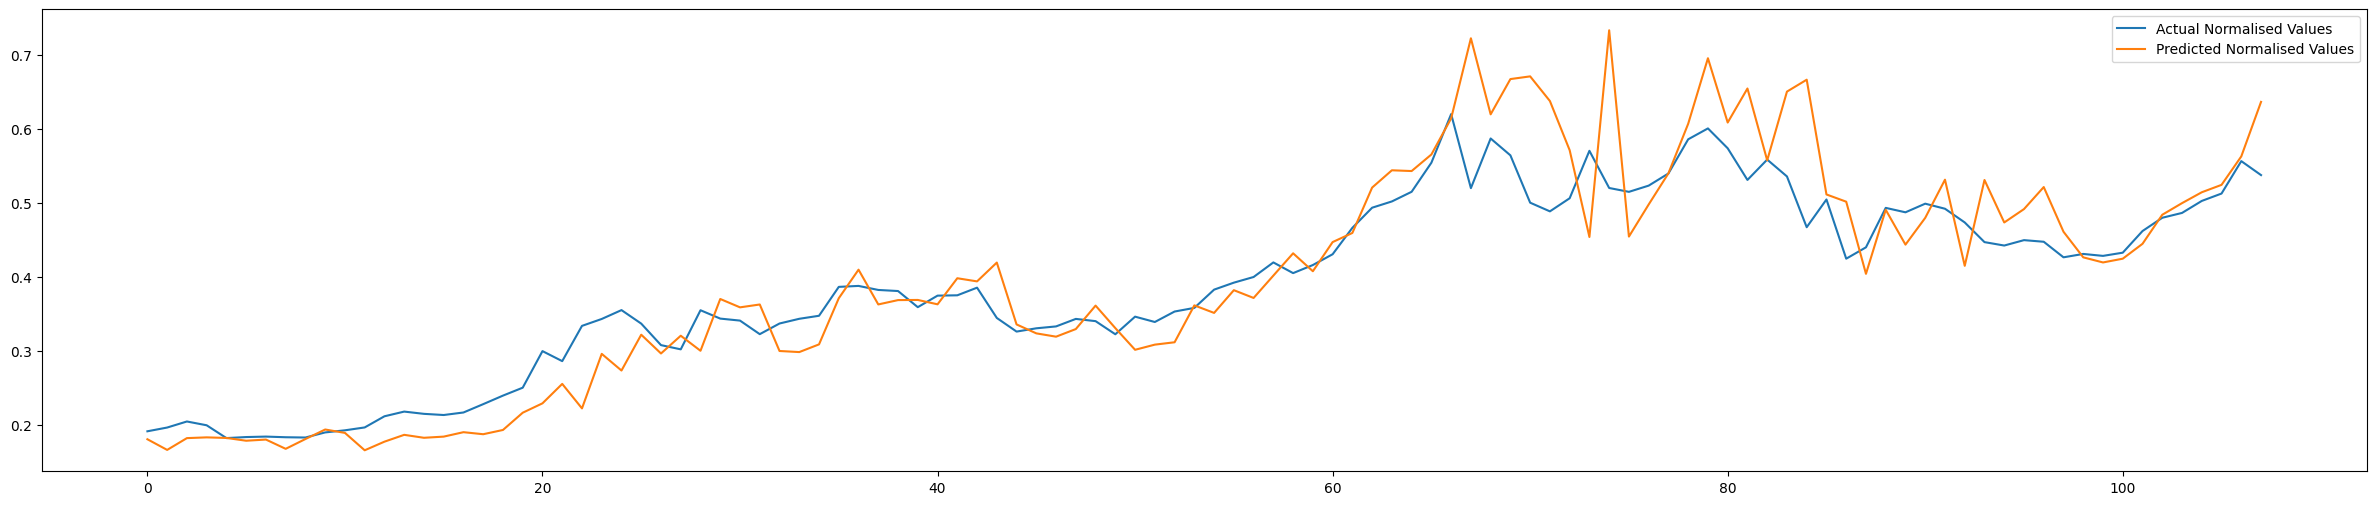

In [ ]:
plt.figure(figsize=(30, 6))
plt.plot(test_y.reset_index()[9])
plt.plot(preds)
plt.legend(["Actual Normalised Values", "Predicted Normalised Values"])
plt.show()

In [ ]:
d1 = (data1max - data1min + 2)[0]
print(type(d1))
denormalized_preds = (preds*d1)[:,0]
# print(denormalized_preds)
denormalized_preds += (data1min + 1)[0]
# print(denormalized_preds)
preds1 = pd.DataFrame(denormalized_preds)
preds1['DATE'] = data1.index[-1*len(preds1):]
preds1 = preds1.set_index('DATE')
print(preds1)

<class 'numpy.float64'>
                       0
DATE                    
2019-04-22   5108.741695
2019-04-23   4853.201831
2019-04-24   5135.976523
2019-04-25   5154.002462
2019-04-26   5139.899290
...                  ...
2019-08-03  10769.952958
2019-08-04  11030.581443
2019-08-05  11207.968427
2019-08-06  11890.187443
2019-08-07  13197.255888

[108 rows x 1 columns]


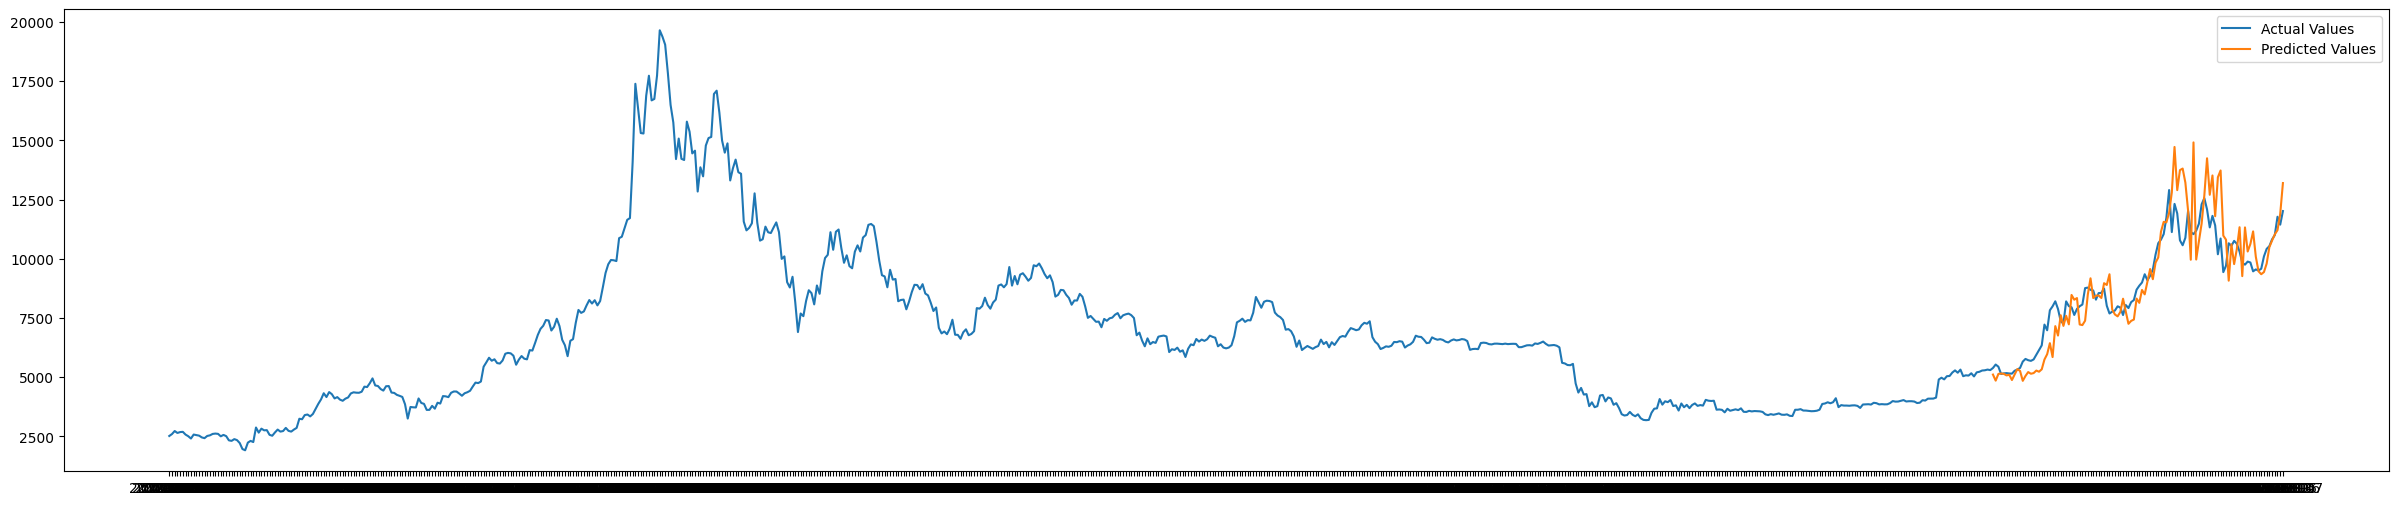

In [ ]:
plt.figure(figsize=(30, 6))
plt.plot(data1)
plt.plot(preds1)
plt.legend(["Actual Values", "Predicted Values"])
plt.show()

In [ ]:
mse = np.mean((np.array(preds1[0]) - np.array(data1.iloc[-1*(len(preds1)):, 0]))**2)
print("mse  "+ str(mse))
print("rmse "+ str(np.sqrt(mse)))

mse  1223225.056016011
rmse 1105.9950524374017
